In [2]:
from diffusers import DiffusionPipeline
import torch
import matplotlib.pyplot as plt
import time
import gc
import psutil

In [9]:
# 시스템 정보 확인
print("=== 시스템 정보 ===")
print(f"GPU 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU 이름: {torch.cuda.get_device_name()}")
    print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print(f"RAM: {psutil.virtual_memory().total / 1e9:.1f} GB")

# GPU 런타임 확인
if not torch.cuda.is_available():
    print("⚠️  GPU가 활성화되지 않았습니다!")
    print("Runtime → Change runtime type → Hardware accelerator → GPU 선택")

=== 시스템 정보 ===
GPU 사용 가능: True
GPU 이름: Tesla T4
GPU 메모리: 15.8 GB
RAM: 13.6 GB


In [8]:
# 메모리 정리
gc.collect()
torch.cuda.empty_cache()

In [5]:
# 코랩에 최적화된 파이프라인 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# 더 가벼운 설정으로 로드
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,  # 메모리 절약 (중요!)
    use_safetensors=True,
    variant="fp16",
    low_cpu_mem_usage=True  # CPU 메모리 절약
)

# GPU로 이동
pipe = pipe.to(device)

# LoRA 로드
pipe.load_lora_weights("alvdansen/phantasma-anime")

# 코랩에서 중요한 최적화들
pipe.enable_model_cpu_offload()  # 모델을 필요할 때만 GPU로
pipe.enable_vae_slicing()        # VAE 메모리 절약
pipe.enable_vae_tiling()         # VAE 타일링
pipe.enable_attention_slicing(1) # Attention 슬라이싱

# xFormers 사용 (코랩에 보통 설치되어 있음)
try:
    pipe.enable_xformers_memory_efficient_attention()
    print("✅ xFormers 최적화 적용됨")
except:
    print("⚠️  xFormers 사용 불가")

import matplotlib.pyplot as plt
import time

prompt = "A teenage boy buying ice cream at a convenience store, casual clothes, holding an ice cream in his hand, bright fluorescent lights, shelves filled with snacks and drinks, everyday modern Japanese convenience store atmosphere."

print("\n=== 이미지 생성 중... ===")
start_time = time.time()

# 코랩에 최적화된 생성 파라미터
image = pipe(
    prompt,
    num_inference_steps=15,  # 더 적게 (코랩에서는 15-20 추천)
    guidance_scale=7.0,
    height=512,              # 더 작은 해상도 (메모리 절약)
    width=512,
    generator=torch.Generator(device=device).manual_seed(42)
).images[0]

end_time = time.time()
generation_time = end_time - start_time

print(f"✅ 생성 완료! 소요시간: {generation_time:.2f}초")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


⚠️  xFormers 사용 불가

=== 이미지 생성 중... ===


  0%|          | 0/15 [00:00<?, ?it/s]

✅ 생성 완료! 소요시간: 20.47초


In [6]:
# 메모리 정리
del pipe
gc.collect()
torch.cuda.empty_cache()

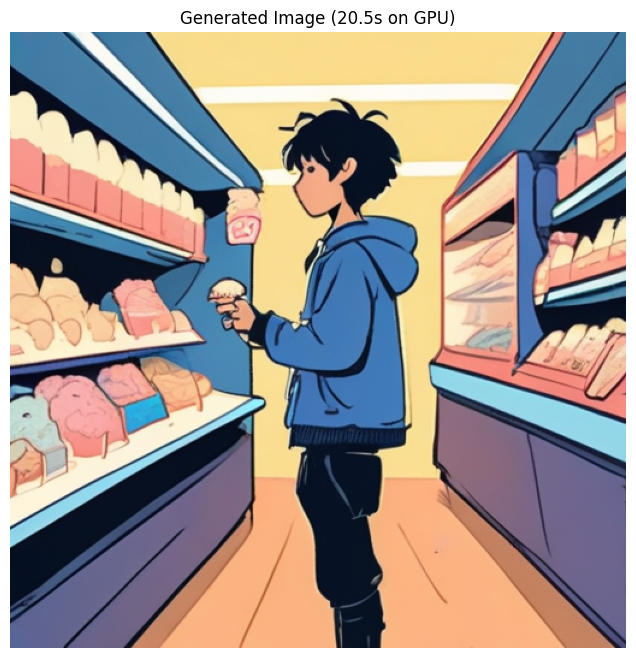

In [7]:
# 결과 표시
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.title(f"Generated Image ({generation_time:.1f}s on {'GPU' if torch.cuda.is_available() else 'CPU'})")
plt.show()